# Plot effective kernel of our filters

In [1]:
import numpy as np
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
import cartopy

In [2]:
import gcm_filters

In [3]:
list(gcm_filters.GridType)

[<GridType.REGULAR: 1>,
 <GridType.REGULAR_WITH_LAND: 2>,
 <GridType.IRREGULAR_WITH_LAND: 3>,
 <GridType.TRIPOLAR_REGULAR_WITH_LAND: 4>,
 <GridType.TRIPOLAR_POP_WITH_LAND: 5>,
 <GridType.VECTOR_C_GRID: 6>]

In [4]:
gcm_filters.required_grid_vars(gcm_filters.GridType.IRREGULAR_WITH_LAND)

['wet_mask', 'dxw', 'dyw', 'dxs', 'dys', 'area', 'kappa_w', 'kappa_s']

## Open MOM6 2/3 degree data

In [5]:
ds = xr.open_dataset('/glade/scratch/gmarques/for_nora/t061.mom6.static.nc', decode_times=False)
ds

<xarray.Dataset>
Dimensions:      (time: 1, xh: 540, xq: 540, yh: 458, yq: 458)
Coordinates:
  * xh           (xh) float64 -286.7 -286.0 -285.3 -284.7 ... 71.33 72.0 72.67
  * yh           (yh) float64 -79.2 -79.08 -78.95 -78.82 ... 87.64 87.71 87.74
  * time         (time) float64 0.0
  * xq           (xq) float64 -286.3 -285.7 -285.0 -284.3 ... 71.67 72.33 73.0
  * yq           (yq) float64 -79.14 -79.01 -78.89 -78.76 ... 87.68 87.73 87.74
Data variables:
    geolon       (yh, xh) float64 ...
    geolat       (yh, xh) float64 ...
    geolon_c     (yq, xq) float64 ...
    geolat_c     (yq, xq) float64 ...
    geolon_u     (yh, xq) float64 ...
    geolat_u     (yh, xq) float64 ...
    geolon_v     (yq, xh) float64 ...
    geolat_v     (yq, xh) float64 ...
    dyCu         (yh, xq) float64 ...
    dxCv         (yq, xh) float64 ...
    dxCu         (yh, xq) float64 ...
    dyCv         (yq, xh) float64 ...
    area_t       (yh, xh) float64 ...
    depth_ocean  (yh, xh) float64 ...
    wet          (yh, xh) float64 ...
    wet_c        (yq, xq) float64 ...
    wet_u        (yh, xq) float64 ...
    wet_v        (yq, xh) float64 ...
    Coriolis     (yq, xq) float64 ...
Attributes:
    filename:   gmom.e22.GJRAv3.TL319_t061_zstar_N65.nuopc.CFC_test.003.mom6....
    title:      MOM6 diagnostic fields table for CESM case: gmom.e22.GJRAv3.T...
    grid_type:  regular
    grid_tile:  N/A

### Create grid info required by `IRREGULAR_WITH_LAND` Laplacian 

In [6]:
wet_mask = ds.wet
area = ds.area_t

# grid spacings
dxw = ds.dxCu.roll(xq=1, roll_coords=False)
dyw = ds.dyCu.roll(xq=1, roll_coords=False)
dxs = ds.dxCv.roll(yq=1, roll_coords=False)
dys = ds.dyCv.roll(yq=1, roll_coords=False)

In [7]:
dxw = dxw.swap_dims({"xq": "xh"})
dyw = dyw.swap_dims({"xq": "xh"})
dxs = dxs.swap_dims({"yq": "yh"})
dys = dys.swap_dims({"yq": "yh"})

In [8]:
dxw = dxw.where(wet_mask)
dyw = dyw.where(wet_mask)
dxs = dxs.where(wet_mask)
dys = dys.where(wet_mask)

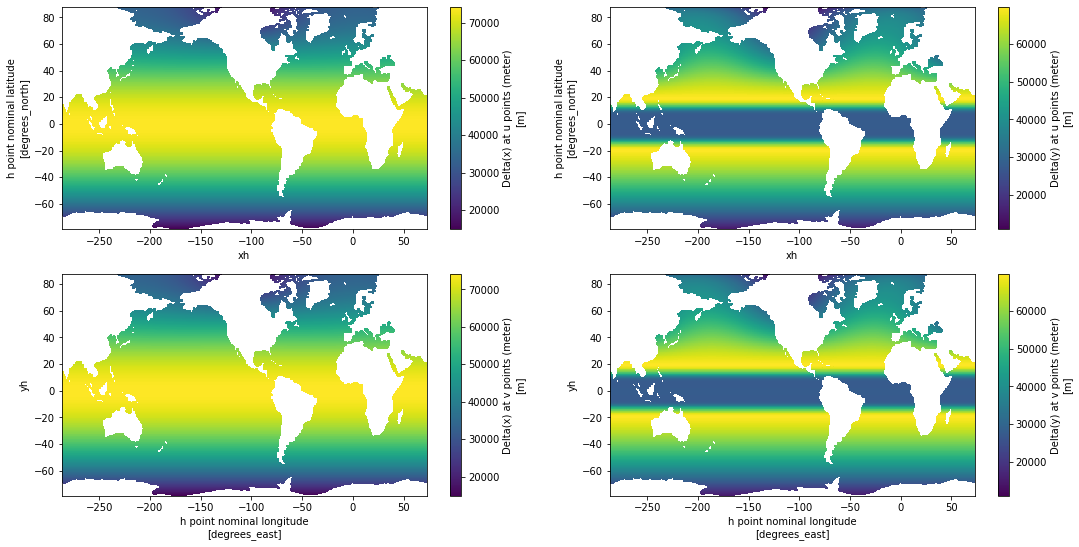

In [9]:
fig,axs = plt.subplots(2,2,figsize=(18,9))
dxw.plot(ax=axs[0,0])
dyw.plot(ax=axs[0,1])
dxs.plot(ax=axs[1,0])
dys.plot(ax=axs[1,1])

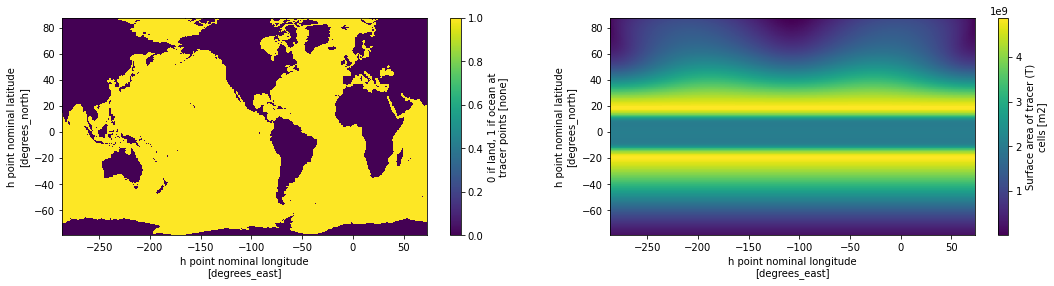

In [10]:
fig,axs = plt.subplots(1,2,figsize=(18,4))
wet_mask.plot(ax=axs[0])
area.plot(ax=axs[1])

In [11]:
dx_min = min(dxw.min(),dyw.min(),dxs.min(),dys.min())
dx_min = dx_min.values
dx_min

array(10916.81749339)

# Define spatial filters

In [12]:
filter_scale_small = 100000
filter_scale_middle = 300000
filter_scale_large = 1000000

### Gaussian

In [13]:
filter_Gaussian_isotropic_small = gcm_filters.Filter(
    filter_scale=filter_scale_small,
    dx_min=dx_min,
    filter_shape=gcm_filters.FilterShape.GAUSSIAN,
    n_steps=0, 
    grid_type=gcm_filters.GridType.IRREGULAR_WITH_LAND,
    grid_vars={'wet_mask': wet_mask, 'dxw': dxw, 'dyw': dyw, 'dxs': dxs, 'dys': dys, 'area': area, 'kappa_w': xr.ones_like(wet_mask), 'kappa_s': xr.ones_like(wet_mask)}
)
filter_Gaussian_isotropic_small

Filter(filter_scale=100000, dx_min=array(10916.81749339), filter_shape=<FilterShape.GAUSSIAN: 1>, transition_width=3.141592653589793, ndim=2, n_steps=11, grid_type=<GridType.IRREGULAR_WITH_LAND: 3>)

In [14]:
filter_Gaussian_isotropic_large = gcm_filters.Filter(
    filter_scale=filter_scale_large,
    dx_min=dx_min,
    filter_shape=gcm_filters.FilterShape.GAUSSIAN,
    n_steps=0, 
    grid_type=gcm_filters.GridType.IRREGULAR_WITH_LAND,
    grid_vars={'wet_mask': wet_mask, 'dxw': dxw, 'dyw': dyw, 'dxs': dxs, 'dys': dys, 'area': area, 'kappa_w': xr.ones_like(wet_mask), 'kappa_s': xr.ones_like(wet_mask)}
)
filter_Gaussian_isotropic_large

/glade/u/home/noraloose/gcm-filters/gcm_filters/filter.py:313: UserWarning: Warning: Filter scale much larger than grid scale -> numerical instability possible
  UserWarning,


Filter(filter_scale=1000000, dx_min=array(10916.81749339), filter_shape=<FilterShape.GAUSSIAN: 1>, transition_width=3.141592653589793, ndim=2, n_steps=101, grid_type=<GridType.IRREGULAR_WITH_LAND: 3>)

In [15]:
filter_Gaussian_anisotropic_small = gcm_filters.Filter(
    filter_scale=filter_scale_small,
    dx_min=dx_min,
    filter_shape=gcm_filters.FilterShape.GAUSSIAN,
    n_steps=0,  
    grid_type=gcm_filters.GridType.IRREGULAR_WITH_LAND,
    grid_vars={'wet_mask': wet_mask, 'dxw': dxw, 'dyw': dyw, 'dxs': dxs, 'dys': dys, 'area': area, 'kappa_w': xr.ones_like(wet_mask), 'kappa_s': 0.33*0.33*xr.ones_like(wet_mask)}
)
filter_Gaussian_anisotropic_small

Filter(filter_scale=100000, dx_min=array(10916.81749339), filter_shape=<FilterShape.GAUSSIAN: 1>, transition_width=3.141592653589793, ndim=2, n_steps=11, grid_type=<GridType.IRREGULAR_WITH_LAND: 3>)

In [16]:
filter_Gaussian_anisotropic_large = gcm_filters.Filter(
    filter_scale=filter_scale_large,
    dx_min=dx_min,
    filter_shape=gcm_filters.FilterShape.GAUSSIAN,
    n_steps=0,  
    grid_type=gcm_filters.GridType.IRREGULAR_WITH_LAND,
    grid_vars={'wet_mask': wet_mask, 'dxw': dxw, 'dyw': dyw, 'dxs': dxs, 'dys': dys, 'area': area, 'kappa_w': xr.ones_like(wet_mask), 'kappa_s': 0.33*0.33*xr.ones_like(wet_mask)}
)
filter_Gaussian_anisotropic_large

/glade/u/home/noraloose/gcm-filters/gcm_filters/filter.py:313: UserWarning: Warning: Filter scale much larger than grid scale -> numerical instability possible
  UserWarning,


Filter(filter_scale=1000000, dx_min=array(10916.81749339), filter_shape=<FilterShape.GAUSSIAN: 1>, transition_width=3.141592653589793, ndim=2, n_steps=101, grid_type=<GridType.IRREGULAR_WITH_LAND: 3>)

### Taper

In [17]:
filter_Taper_isotropic_small = gcm_filters.Filter(
    filter_scale=filter_scale_small,
    dx_min=dx_min,
    filter_shape=gcm_filters.FilterShape.TAPER,
    n_steps=0,  
    grid_type=gcm_filters.GridType.IRREGULAR_WITH_LAND,
    grid_vars={'wet_mask': wet_mask, 'dxw': dxw, 'dyw': dyw, 'dxs': dxs, 'dys': dys, 'area': area, 'kappa_w': xr.ones_like(wet_mask), 'kappa_s': xr.ones_like(wet_mask)}
)
filter_Taper_isotropic_small

Filter(filter_scale=100000, dx_min=array(10916.81749339), filter_shape=<FilterShape.TAPER: 2>, transition_width=3.141592653589793, ndim=2, n_steps=36, grid_type=<GridType.IRREGULAR_WITH_LAND: 3>)

In [18]:
filter_Taper_isotropic_middle = gcm_filters.Filter(
    filter_scale=filter_scale_middle,
    dx_min=dx_min,
    filter_shape=gcm_filters.FilterShape.TAPER,
    n_steps=0,  
    grid_type=gcm_filters.GridType.IRREGULAR_WITH_LAND,
    grid_vars={'wet_mask': wet_mask, 'dxw': dxw, 'dyw': dyw, 'dxs': dxs, 'dys': dys, 'area': area, 'kappa_w': xr.ones_like(wet_mask), 'kappa_s': xr.ones_like(wet_mask)}
)
filter_Taper_isotropic_middle

/glade/u/home/noraloose/gcm-filters/gcm_filters/filter.py:313: UserWarning: Warning: Filter scale much larger than grid scale -> numerical instability possible
  UserWarning,


Filter(filter_scale=300000, dx_min=array(10916.81749339), filter_shape=<FilterShape.TAPER: 2>, transition_width=3.141592653589793, ndim=2, n_steps=108, grid_type=<GridType.IRREGULAR_WITH_LAND: 3>)

In [19]:
filter_Taper_anisotropic_small = gcm_filters.Filter(
    filter_scale=filter_scale_small,
    dx_min=dx_min,
    filter_shape=gcm_filters.FilterShape.TAPER,
    n_steps=0,  
    grid_type=gcm_filters.GridType.IRREGULAR_WITH_LAND,
    grid_vars={'wet_mask': wet_mask, 'dxw': dxw, 'dyw': dyw, 'dxs': dxs, 'dys': dys, 'area': area, 'kappa_w': xr.ones_like(wet_mask), 'kappa_s': 0.33*0.33*xr.ones_like(wet_mask)}
)
filter_Taper_anisotropic_small

Filter(filter_scale=100000, dx_min=array(10916.81749339), filter_shape=<FilterShape.TAPER: 2>, transition_width=3.141592653589793, ndim=2, n_steps=36, grid_type=<GridType.IRREGULAR_WITH_LAND: 3>)

In [20]:
filter_Taper_anisotropic_middle = gcm_filters.Filter(
    filter_scale=filter_scale_middle,
    dx_min=dx_min,
    filter_shape=gcm_filters.FilterShape.TAPER,
    n_steps=0,  
    grid_type=gcm_filters.GridType.IRREGULAR_WITH_LAND,
    grid_vars={'wet_mask': wet_mask, 'dxw': dxw, 'dyw': dyw, 'dxs': dxs, 'dys': dys, 'area': area, 'kappa_w': xr.ones_like(wet_mask), 'kappa_s': 0.33*0.33*xr.ones_like(wet_mask)}
)
filter_Taper_anisotropic_middle

/glade/u/home/noraloose/gcm-filters/gcm_filters/filter.py:313: UserWarning: Warning: Filter scale much larger than grid scale -> numerical instability possible
  UserWarning,


Filter(filter_scale=300000, dx_min=array(10916.81749339), filter_shape=<FilterShape.TAPER: 2>, transition_width=3.141592653589793, ndim=2, n_steps=108, grid_type=<GridType.IRREGULAR_WITH_LAND: 3>)

### Filter delta functions close to Antarctic Peninsula

In [21]:
delta1 = 0 * xr.ones_like(ds.yh*ds.xh) 
delta1[120, 250] = 1
delta1 = delta1.where(wet_mask)
delta1 = delta1.chunk({'yh': len(ds.yh), 'xh': len(ds.xh)})

delta2 = 0 * xr.ones_like(ds.yh*ds.xh) 
delta2[60, 270] = 1
delta2 = delta2.where(wet_mask)
delta2 = delta2.chunk({'yh': len(ds.yh), 'xh': len(ds.xh)})

delta3 = 0 * xr.ones_like(ds.yh*ds.xh) 
delta3[100, 320] = 1
delta3 = delta3.where(wet_mask)
delta3 = delta3.chunk({'yh': len(ds.yh), 'xh': len(ds.xh)})

delta4 = 0 * xr.ones_like(ds.yh*ds.xh) 
delta4[116, 280] = 1
delta4 = delta4.where(wet_mask)
delta4 = delta4.chunk({'yh': len(ds.yh), 'xh': len(ds.xh)})


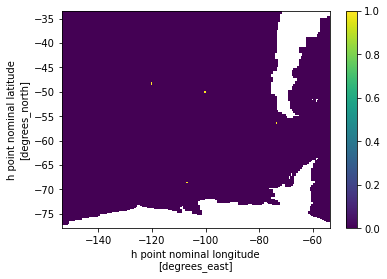

In [22]:
# Nordic Seas
xh0 = 200
xh1 = 350
yh0 = 10
yh1 = 150
xslice = slice(xh0, xh1)
yslice = slice(yh0, yh1)

(delta1+delta2+delta3+delta4).isel(yh=yslice, xh=xslice).plot()
#delta1.plot()

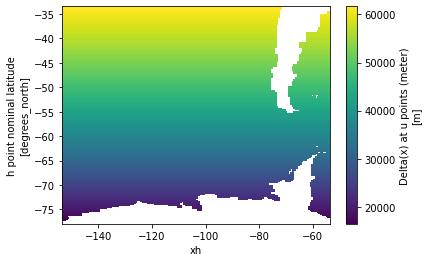

In [23]:
dxw.isel(yh=yslice, xh=xslice).plot()

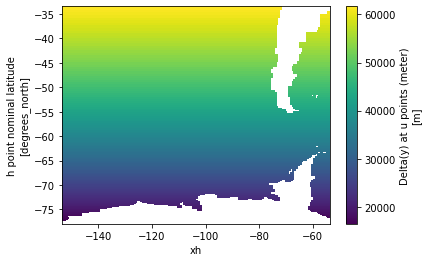

In [24]:
dyw.isel(yh=yslice, xh=xslice).plot()

In [25]:
from dask.diagnostics import ProgressBar

In [26]:
%time delta4_filtered_Gaussian_isotropic_small = filter_Gaussian_isotropic_small.apply(delta4, dims=['yh', 'xh'])
with ProgressBar():
    delta4_filtered_Gaussian_isotropic_small = delta4_filtered_Gaussian_isotropic_small.compute()

CPU times: user 24.7 ms, sys: 2.97 ms, total: 27.7 ms
Wall time: 27.7 ms
[########################################] | 100% Completed |  0.1s


In [27]:
%time delta4_filtered_Gaussian_anisotropic_small = filter_Gaussian_anisotropic_small.apply(delta4, dims=['yh', 'xh'])
with ProgressBar():
    delta4_filtered_Gaussian_anisotropic_small = delta4_filtered_Gaussian_anisotropic_small.compute()

CPU times: user 26.3 ms, sys: 30 µs, total: 26.3 ms
Wall time: 30.2 ms
[########################################] | 100% Completed |  0.1s


In [28]:
%time delta1_filtered_Gaussian_isotropic_large = filter_Gaussian_isotropic_large.apply(delta1, dims=['yh', 'xh'])
%time delta2_filtered_Gaussian_isotropic_large = filter_Gaussian_isotropic_large.apply(delta2, dims=['yh', 'xh'])
%time delta3_filtered_Gaussian_isotropic_large = filter_Gaussian_isotropic_large.apply(delta3, dims=['yh', 'xh'])
with ProgressBar():
    delta1_filtered_Gaussian_isotropic_large = delta1_filtered_Gaussian_isotropic_large.compute()
    delta2_filtered_Gaussian_isotropic_large = delta2_filtered_Gaussian_isotropic_large.compute()
    delta3_filtered_Gaussian_isotropic_large = delta3_filtered_Gaussian_isotropic_large.compute()

CPU times: user 33.4 ms, sys: 50 µs, total: 33.5 ms
Wall time: 36.3 ms
CPU times: user 32.5 ms, sys: 0 ns, total: 32.5 ms
Wall time: 32.5 ms
CPU times: user 32.6 ms, sys: 849 µs, total: 33.5 ms
Wall time: 36.6 ms
[########################################] | 100% Completed |  0.5s
[########################################] | 100% Completed |  0.5s
[########################################] | 100% Completed |  0.5s


In [29]:
%time delta1_filtered_Gaussian_anisotropic_large = filter_Gaussian_anisotropic_large.apply(delta1, dims=['yh', 'xh'])
%time delta2_filtered_Gaussian_anisotropic_large = filter_Gaussian_anisotropic_large.apply(delta2, dims=['yh', 'xh'])
%time delta3_filtered_Gaussian_anisotropic_large = filter_Gaussian_anisotropic_large.apply(delta3, dims=['yh', 'xh'])
with ProgressBar():
    delta1_filtered_Gaussian_anisotropic_large = delta1_filtered_Gaussian_anisotropic_large.compute()
    delta2_filtered_Gaussian_anisotropic_large = delta2_filtered_Gaussian_anisotropic_large.compute()
    delta3_filtered_Gaussian_anisotropic_large = delta3_filtered_Gaussian_anisotropic_large.compute()

CPU times: user 31.3 ms, sys: 2.95 ms, total: 34.3 ms
Wall time: 37.1 ms
CPU times: user 32.5 ms, sys: 0 ns, total: 32.5 ms
Wall time: 32.5 ms
CPU times: user 31.7 ms, sys: 980 µs, total: 32.7 ms
Wall time: 36.1 ms
[########################################] | 100% Completed |  0.5s
[########################################] | 100% Completed |  0.5s
[########################################] | 100% Completed |  0.5s


In [30]:
%time delta4_filtered_Taper_isotropic_small = filter_Taper_isotropic_small.apply(delta4, dims=['yh', 'xh'])
with ProgressBar():
    delta4_filtered_Taper_isotropic_small = delta4_filtered_Taper_isotropic_small.compute()

CPU times: user 27.7 ms, sys: 44 µs, total: 27.7 ms
Wall time: 30.6 ms
[########################################] | 100% Completed |  0.2s


In [31]:
%time delta4_filtered_Taper_anisotropic_small = filter_Taper_anisotropic_small.apply(delta4, dims=['yh', 'xh'])
with ProgressBar():
    delta4_filtered_Taper_anisotropic_small = delta4_filtered_Taper_anisotropic_small.compute()

CPU times: user 27.5 ms, sys: 32 µs, total: 27.5 ms
Wall time: 30.4 ms
[########################################] | 100% Completed |  0.2s


In [32]:
%time delta1_filtered_Taper_isotropic_middle = filter_Taper_isotropic_middle.apply(delta1, dims=['yh', 'xh'])
%time delta2_filtered_Taper_isotropic_middle = filter_Taper_isotropic_middle.apply(delta2, dims=['yh', 'xh'])
%time delta3_filtered_Taper_isotropic_middle = filter_Taper_isotropic_middle.apply(delta3, dims=['yh', 'xh'])
with ProgressBar():
    delta1_filtered_Taper_isotropic_middle = delta1_filtered_Taper_isotropic_middle.compute()
    delta2_filtered_Taper_isotropic_middle = delta2_filtered_Taper_isotropic_middle.compute()
    delta3_filtered_Taper_isotropic_middle = delta3_filtered_Taper_isotropic_middle.compute()

CPU times: user 34 ms, sys: 56 µs, total: 34 ms
Wall time: 36.8 ms
CPU times: user 33.1 ms, sys: 0 ns, total: 33.1 ms
Wall time: 33.1 ms
CPU times: user 33.1 ms, sys: 0 ns, total: 33.1 ms
Wall time: 34.2 ms
[########################################] | 100% Completed |  0.6s
[########################################] | 100% Completed |  0.7s
[########################################] | 100% Completed |  0.7s


In [33]:
%time delta1_filtered_Taper_anisotropic_middle = filter_Taper_anisotropic_middle.apply(delta1, dims=['yh', 'xh'])
%time delta2_filtered_Taper_anisotropic_middle = filter_Taper_anisotropic_middle.apply(delta2, dims=['yh', 'xh'])
%time delta3_filtered_Taper_anisotropic_middle = filter_Taper_anisotropic_middle.apply(delta3, dims=['yh', 'xh'])
with ProgressBar():
    delta1_filtered_Taper_anisotropic_middle = delta1_filtered_Taper_anisotropic_middle.compute()
    delta2_filtered_Taper_anisotropic_middle = delta2_filtered_Taper_anisotropic_middle.compute()
    delta3_filtered_Taper_anisotropic_middle = delta3_filtered_Taper_anisotropic_middle.compute()

CPU times: user 36.3 ms, sys: 17 µs, total: 36.4 ms
Wall time: 39.1 ms
CPU times: user 32 ms, sys: 976 µs, total: 33 ms
Wall time: 33 ms
CPU times: user 33 ms, sys: 2 µs, total: 33 ms
Wall time: 33 ms
[########################################] | 100% Completed |  0.6s
[########################################] | 100% Completed |  0.7s
[########################################] | 100% Completed |  0.6s


## Plot effective filter kernels

In [35]:
import matplotlib.pylab as pylab
from matplotlib import cm
cmap = cm.get_cmap('RdBu_r')
cmap.set_bad(color='0.8') 

params = {'legend.fontsize': 'large',
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large',
         'font.size': 20}
pylab.rcParams.update(params)

/glade/work/noraloose/my_npl_clone/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:305: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/glade/work/noraloose/my_npl_clone/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:341: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


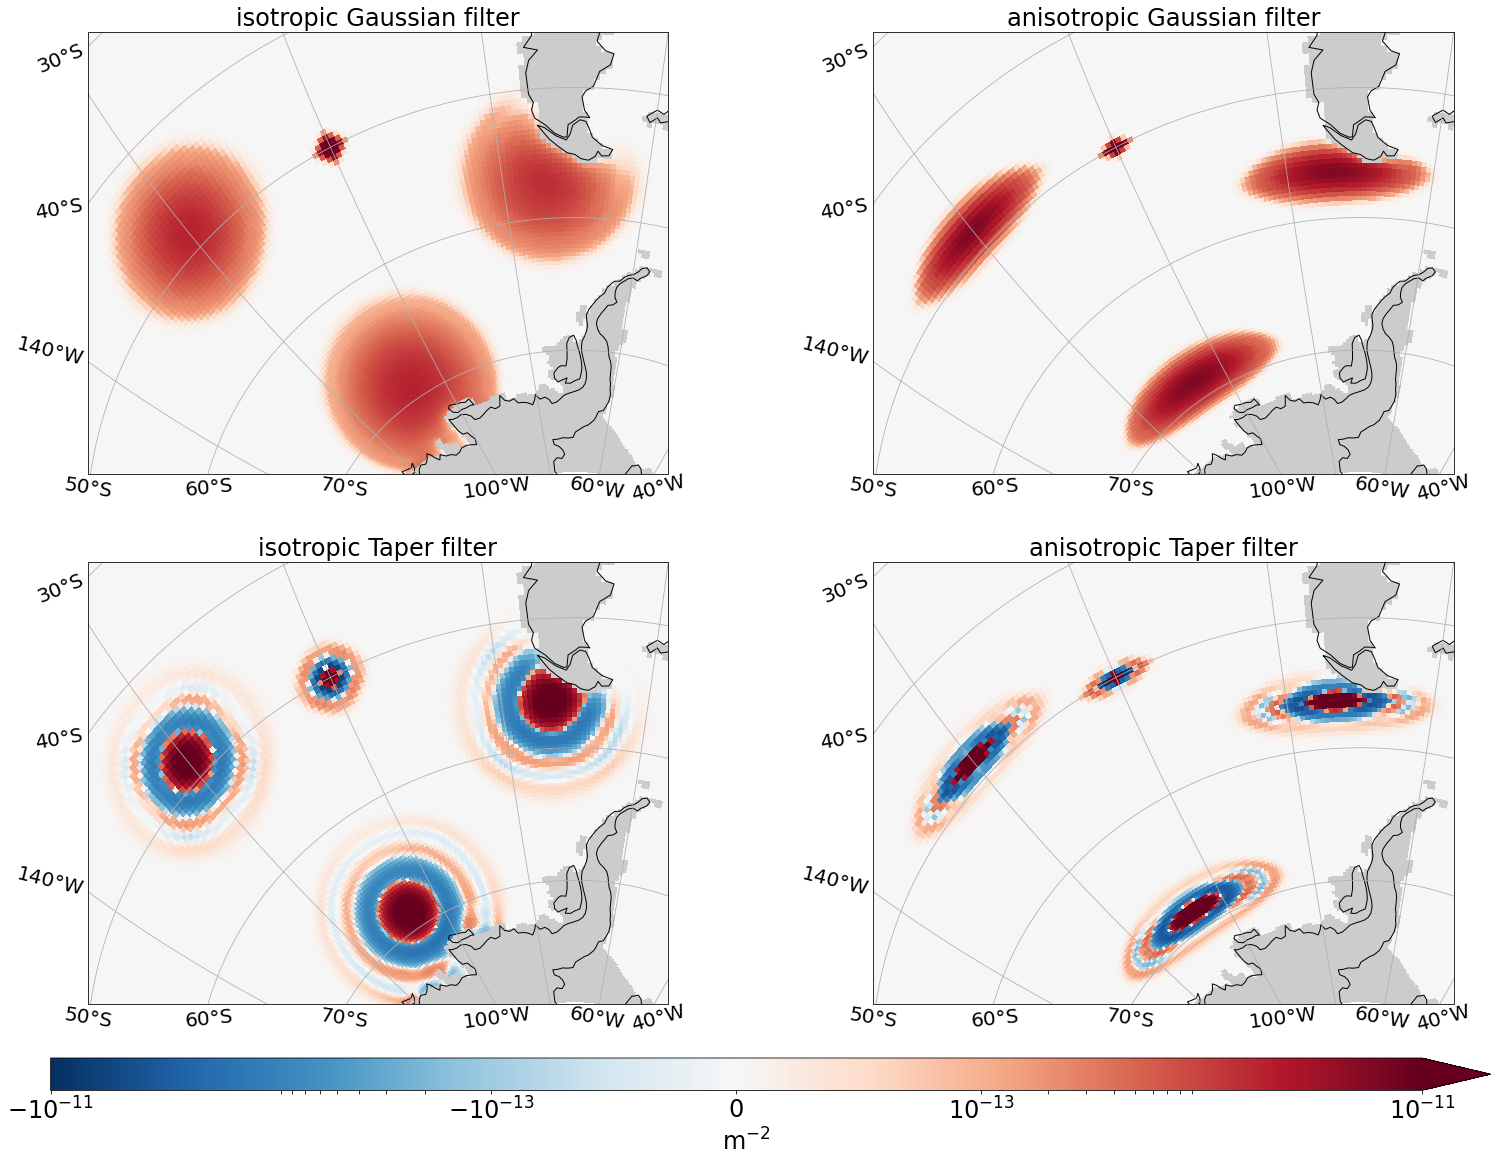

In [36]:
central_lon = -70
central_lat = -66
vmax = 1e-11
linthresh = 1e-13

fig,axs = plt.subplots(2,2,figsize=(25,15),subplot_kw={'projection':ccrs.Orthographic(central_lon, central_lat)})

        
((delta1_filtered_Gaussian_isotropic_large+delta2_filtered_Gaussian_isotropic_large+delta3_filtered_Gaussian_isotropic_large+delta4_filtered_Gaussian_isotropic_small)/area).plot(
    ax=axs[0,0],
    vmin=-vmax, vmax=vmax ,cmap='RdBu_r',
    norm=mpl.colors.SymLogNorm(linthresh=linthresh, base=10),
    add_colorbar=False,
    transform=ccrs.PlateCarree()
)

((delta1_filtered_Gaussian_anisotropic_large+delta2_filtered_Gaussian_anisotropic_large+delta3_filtered_Gaussian_anisotropic_large+delta4_filtered_Gaussian_anisotropic_small)/area).plot(
    ax=axs[0,1],
    vmin=-vmax, vmax=vmax ,cmap='RdBu_r',
    norm=mpl.colors.SymLogNorm(linthresh=linthresh, base=10),
    add_colorbar=False,
    transform=ccrs.PlateCarree()
)

((delta1_filtered_Taper_isotropic_middle+delta2_filtered_Taper_isotropic_middle+delta3_filtered_Taper_isotropic_middle+delta4_filtered_Taper_isotropic_small)/area).plot(
    ax=axs[1,0],
    vmin=-vmax, vmax=vmax ,cmap='RdBu_r',
    norm=mpl.colors.SymLogNorm(linthresh=linthresh, base=10),
    add_colorbar=False,
    transform=ccrs.PlateCarree()
)

p=((delta1_filtered_Taper_anisotropic_middle+delta2_filtered_Taper_anisotropic_middle+delta3_filtered_Taper_anisotropic_middle+delta4_filtered_Taper_anisotropic_small)/area).plot(
    ax=axs[1,1],
    vmin=-vmax, vmax=vmax ,cmap='RdBu_r',
    norm=mpl.colors.SymLogNorm(linthresh=linthresh, base=10),
    add_colorbar=False,
    transform=ccrs.PlateCarree()
)
for ax in axs.flatten():
    ax.coastlines()
    ax.set_extent([-135, -60, -68, -45], crs=ccrs.PlateCarree())
    gl = ax.gridlines(draw_labels=True)
    gl.xlabels_top = False
    gl.ylabels_right = False
    
    #gl.ylocator = mticker.FixedLocator([-68,-66,-64])
    #gl.xlocator = mticker.FixedLocator([-78,-76,-74,-72,-70,-68,-66,-64])
    
axs[0,0].set(title='isotropic Gaussian filter')
axs[0,1].set(title='anisotropic Gaussian filter')
axs[1,0].set(title='isotropic Taper filter')
axs[1,1].set(title='anisotropic Taper filter')
# colorbar
fig.subplots_adjust(left=0.1, bottom=-0.02)
cax = fig.add_axes([0.1, -0.1, 0.8, 0.03])
cbar = fig.colorbar(p, cax=cax, orientation='horizontal',extend='max')
cbar.set_label(label=r'm$^{-2}$', horizontalalignment='right')

plt.savefig('figures/effective_kernel_ACC_log_divided_by_area_latlon.pdf',dpi=400,bbox_inches='tight',pad_inches=0)
# plt.savefig('figures/effective_kernel_ACC_log_divided_by_area_latlon.png',dpi=400,bbox_inches='tight',pad_inches=0) # doesn't save all tick labels...